In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
np.random.seed(10) # Set a seed to make our results reproducible

#### About the data
* Title:
The title of the article

* text:
The text of the article

* subject:
The subject of the article

* date:
The date at which the article was posted

### Loading the data

In [39]:
X_train = pd.read_csv('news_train.csv', sep=",")
y_train = X_train['labels']

#### Quick look at the data

In [4]:
X_train.head()

,title,text,subject,date,labels
0,U.S. House panel offers alternative to retirem...,WASHINGTON (Reuters) - Legislation to bypass t...,politicsNews,"February 3, 2016",Real
1,THE SMARTEST WOMAN In Politics: “How Trump Can...,Monica Crowley offers some of the most brillia...,left-news,"Sep 22, 2016",Fake
2,CNN CLOWN Who Cries About “FAKE NEWS” Uses Unv...,The video featured a Youtube prankster named A...,politics,"Dec 23, 2016",Fake
3,NAACP CHIEF Asks BLM Rioters To “Show up en ma...,Put down the bricks and vote! Hmmm I wonder if...,politics,"Jul 10, 2016",Fake
4,Possible Putin-Trump meeting in Vietnam still ...,MOSCOW (Reuters) - The Kremlin said on Thursda...,worldnews,"November 9, 2017",Real


#### Understanding the data: Proportion of fake and real news

It can be seen that our training set has approximately as many fake news as real news

(array([0, 1]), <a list of 2 Text xticklabel objects>)

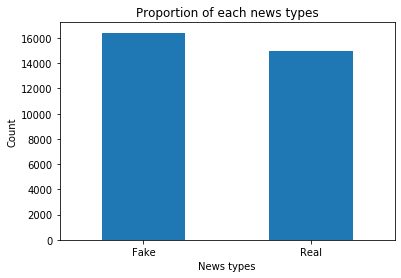

In [7]:
import matplotlib.pyplot as plt
X_train['labels'].value_counts().plot(kind='bar', title="Proportion of each news types")
plt.ylabel('Count')
plt.xlabel('News types')
plt.xticks(rotation=0)

#### News subjects by news types
This graph is interesting, it appears that real news are generally fall under pioticsNews and world news subjects.
And fake news seem to appear mostly in general news as well as news about politics 

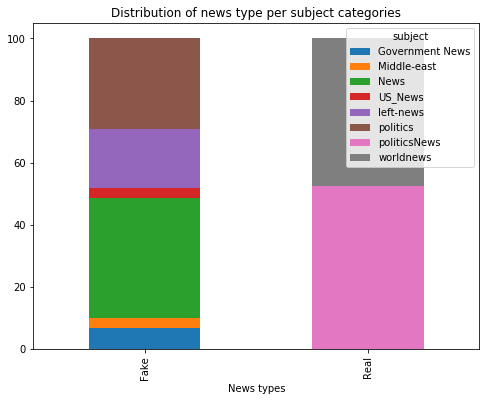

In [41]:
from process_data import plot_marginal_distribution
plot_marginal_distribution(
    X_train.rename(columns={'labels': 'News types'}), 
                           var1='subject', 
                           var2='News types', 
                           title='Distribution of news type per subject categories')

#### Compare article title patterns accross news types

Fake news seem to have longer titles

In [20]:
import warnings
warnings.filterwarnings('ignore')
# after this command, restart the Kernel if necessary
try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns

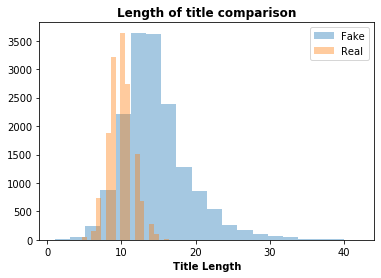

In [44]:
# Restart the kernel if this fails
plt.figure(figsize=(6,4))
X_train['title_length'] = X_train['title'].apply(lambda x : len(x.strip().split()))
sns.distplot(X_train[X_train['labels'] == 'Fake']['title_length'], 
             kde=False, label='Fake', bins=20)
sns.distplot(X_train[X_train['labels'] == 'Real']['title_length'], 
             kde=False, label='Real', bins=20)
plt.xlabel('Title Length', weight='bold')
plt.title('Length of title comparison', weight='bold')
plt.legend()
plt.show()

In [22]:
text = X_train.loc[0, 'text']
text

'WASHINGTON (Reuters) - Legislation to bypass the U.S. Labor Department and have Congress set standards for brokers who give retirement advice passed a major committee on Wednesday and is now headed to the full House of Representatives. Although the bill faces slim chances of becoming law, it reveals the depth of feuding in Washington over the 2010 Dodd-Frank Wall Street reform law’s requirement that retirement advisers follow a “fiduciary” standard that puts their clients’ interests first. The requirement aims to end potential conflicts of interest by brokers who advise on individual retirement accounts and to protect consumers from buying unnecessary investment products that line brokers’ pockets.  Last week, the Labor Department sent a revised proposal for an adviser rule to the White House’s Office of Management and Budget. Details will not be made public until the White House completes its review. This was the department’s second stab at a rule. Wide criticism from the industry an

#### Pre-processing
For simplicity, we also ignore the title of the article, and focus solely on the actual text of the article

Data prepricessing will essentially consist of:
- removing stop words
- removing special characters
- removing hyperlinks
- lower case the entire text

In [26]:
import re

def remove_special_characters(text):
    """ remove special characters from text """
    delete_chars = "[]()@''+&'"
    space_chars = "_.-"
    table = dict((ord(c), " ") for c in space_chars)
    table.update(dict((ord(c), None) for c in delete_chars))
    return text.translate(table)


def text_pre_processing(text, stop_words=True):
    """ remove special characters, hyperlinks, and lowercase everything """
    # remove hyperlinks
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
    text = re.sub('<[^>]*>', '', text)
    
    # remove custom special characters from our text
    cleaned_text = remove_special_characters(text)
    
    return cleaned_text
# text_pre_processing(text)

'washington reuters   legislation to bypass the u s  labor department and have congress set standards for brokers who give retirement advice passed a major committee on wednesday and is now headed to the full house of representatives  although the bill faces slim chances of becoming law, it reveals the depth of feuding in washington over the 2010 dodd frank wall street reform law’s requirement that retirement advisers follow a “fiduciary” standard that puts their clients’ interests first  the requirement aims to end potential conflicts of interest by brokers who advise on individual retirement accounts and to protect consumers from buying unnecessary investment products that line brokers’ pockets   last week, the labor department sent a revised proposal for an adviser rule to the white house’s office of management and budget  details will not be made public until the white house completes its review  this was the department’s second stab at a rule  wide criticism from the industry and 

#### Create a corpus from cleanned text

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
train_corpus = [text_pre_processing(text) for text in X_train['text']]

#### Creating features, 

we will use the TfidfVectorizer class of sklearn feature_extraction class.
We initialize TfidfVectorizer with stop words from the English language and a maximum document frequency of 0.8 (terms with a higher document frequency will be discarded). 
Stop words are the most common words in a language that are to be filtered out before processing the natural language data. 

And a TfidfVectorizer turns a collection of raw documents into a matrix of TF-IDF features.

TF = term frequency
IDF = inverse document frequency 

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, strip_accents='unicode')

train_corpus = [text_pre_processing(text) for text in X_train['text']]
# Fit and transform the train set
features = tf_idf_vectorizer.fit_transform(train_corpus)

#### Training the model

In [48]:
from sklearn.linear_model import LogisticRegression


classifier = LogisticRegression(random_state=12, class_weight='balanced')
# Train the model
y_train = [1 if x == 'Real' else 0 for x in y_train]
classifier = classifier.fit(features, y_train)

#### Preparing test data and evaluate the model

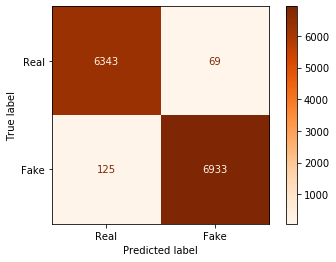

In [49]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

X_test = pd.read_csv('news_test.csv', sep=",")
y_test = [1 if x == 'Real' else 0 for x in X_test['labels']]

test_corpus = [text_pre_processing(text) for text in X_test['text']]
X_test = tf_idf_vectorizer.transform(test_corpus)

y_preds = classifier.predict(X_test)

class_names = ['Real', 'Fake']
disp = plot_confusion_matrix(classifier, X_test, 
                             y_test, display_labels=class_names, 
                             cmap=plt.cm.Oranges, 
                             normalize=None, values_format='.0f', labels=[1, 0])

#### Saving the model and the TfidfVectorizer to the disk

In [37]:
import pickle

with open('./webservice/static/news_verification_model.pkl', 'wb') as stream:
    pickle.dump(classifier, stream)


with open('./webservice/static/tfidf_feature_extractor.pkl', 'wb') as stream:
    pickle.dump(tf_idf_vectorizer, stream)